![image.png](plots/portada2.png)

# Introducción
___
¡Bienvenidos a las prácticas de __árboles de decisión__! Los árboles de decisión son uno de los algoritmos más versátiles de machine learning. Son capaces de resolver problemas de __clasificación__ y de __regresión__ en conjuntos de datos complejos, y no necesitan asumir ninguna hipótesis adicional sobre los datos. Además, los árboles constituyen la base de las estrategias de __ensemble__, entre las que están algunos de los algoritmos más utilizados a día de hoy.

Como bibliografía adicional para estas sesiones recomiendo:
* [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/). Capítulo 6

Para resolver estas prácticas necesitaremos los paquetes de Python de `numpy`, `pandas`, `matplotlib` y `sklearn`, empecemos cargando estos paquetes:

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(5) # Los resultados del notebook serán los mismos en cada ejecución

import os
num_cores = os.cpu_count()

# Árboles de clasificación
___

Construyamos un árbol de clasificación sencillo empleando el conjunto de datos de iris

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

iris = load_iris()

X_iris = iris.data[:, 2:] # petal length y width
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

Podemos visualizar el árbol que acabamos de construir usando la función `plot_tree`:

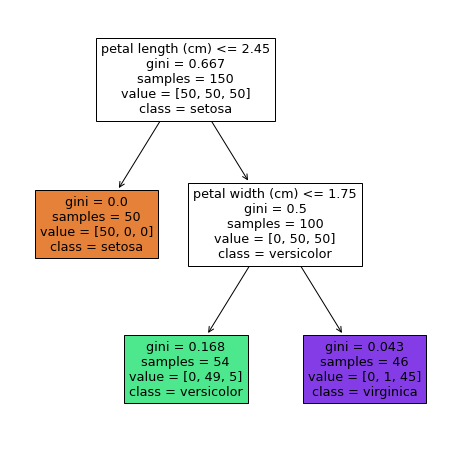

In [3]:
fig = plt.figure(figsize=(8,8))
_ = plot_tree(tree_clf, 
              feature_names=iris.feature_names[2:],  
              class_names=iris.target_names,
              filled=True)

En cada recuadro de esta representación tenemos 5 lineas:
1. La variable que define la regla de decisión.
2. El grado de impureza del nodo. Un nodo es puro (`gini=0`) si todas las observaciones pertenecen a la misma clase  (veremos más adelante lo que significa).
3. El número de observaciones en el nodo.
4. El número de observaciones de cada clase en ese nodo.
5. La clase predominante en ese nodo.

Al nodo inicial se le llama __nodo raiz__, y de cada nodo salen otros dos nodos hijos, __izquierda__ y __derecha__. Todo nodo que no tenga hijos se llama __hoja__.

De esta forma, imaginemos que tenemos una flor que queremos clasificar usando este algoritmo. Empezaríamos en el nodo raiz, dibujado en blanco:
* En este nodo nos indican que hay 150 observaciones, 50 observaciones de cada clase. La función de decisión se basa en la variable `sepal length (cm)`. 
    * Si la flor tiene una longitud de sépalo menor o igual que 2.45 cm, nos trasladamos al nodo hijo de la izquierda. En este nodo tenemos 50 observaciones, todas de la clase setosa. Es un nodo hoja así que predeciríamos por tanto que la flor es del tipo Setosa
    * Si la flor tiene una longitud de sépalo mayor que 2.45 cm, nos trasladamos al nodo hijo de la derecha. Hay 100 observaciones en este nodo, y la función de decisión se basa en `sepal width (cm)`.
        * Si la anchura del sépalo es menor o igual que 1.75 nos trasladamos al nodo de la izquierda. Vemos que aquí hay 54 observaciones, la mayoría de ellas versicolor. Es un nodo hoja así que predeciríamos que la nueva flor es versicolor
        * Si la anchura del sépalo es mayor que 1.75 nos trasladamos al nodo de la derecha. Vemos que aquí hay 46 observaciones, la mayoría de ellas virginica. Es un nodo hoja, así que predeciríamos que la nueva flor es virginica
    
### Representación 2D
Ya que en el ejemplo anterior estamos utilizando solo dos variables para hacer las predicciones, podemos hacer una representación gráfica de este árbol de decisión, para entender mejor cómo 

In [4]:
def plot_decision_boundary(clf, axes):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.3)

Text(3.2, 1.8, 'Depth=1')

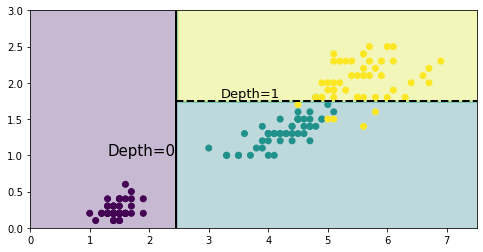

In [5]:
plt.figure(figsize=(8, 4))

plot_decision_boundary(tree_clf, axes=[0, 7.5, 0, 3])
plt.scatter(X_iris[:,0], X_iris[:,1], c=y_iris)

plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.30, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)

### <font color='D12828'> Ejercicio: </font>

* ¿Los árboles de decisión se ven afectados por la escala de las variables? Es decir, ¿puede estandarizar los datos antes de construir el árbol cambiar la estructura del árbol?
* Compruebalo. Estandariza la matriz X (resta la media y divide por la desviación típica) y construye un nuevo árbol de clasificación.

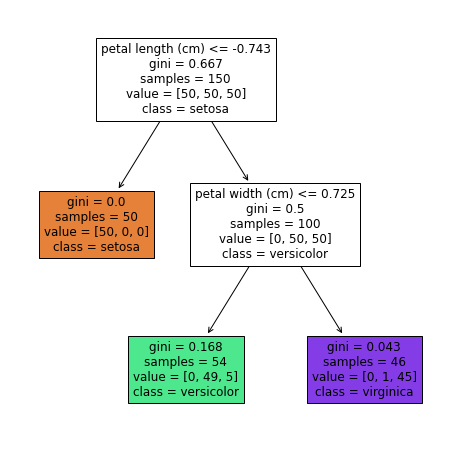

In [6]:
# Ejercicio

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_iris)

scaled_tree = DecisionTreeClassifier(max_depth=2, random_state=42)
scaled_tree.fit(X_scaled, y_iris)

fig = plt.figure(figsize=(8,8))
_ = plot_tree(scaled_tree,
             feature_names = iris.feature_names[2:],
             class_names = iris.target_names,
             filled=True)

## Estimación de probabilidades

Observa que en cada nodo hoja nos indican  la cantidad de observaciones que pertenecen a cada categoría. A la a hora de hacer predicciones __considera los ratios de cada clase como probabilidades__, y asigna la nueva flor a la clase con mayor probabilidad. Por ejemplo, imaginemos que tenemos una flor cuyos petalos miden 5cm de largo y 1.5 de ancho. En el primer arbol que construímos, esto la situaría en el nodo izquierdo del segundo nivel. Ese nodo tiene 54 plantas: 0 setosas (0%) 49 versicolor (90.7%) y 5 virginica (9.3%). Al pedir que haga una predicción, la clasificará como versicolor (clase 1):

In [7]:
print(tree_clf.predict_proba([[5, 1.5]]))

print(tree_clf.predict([[5, 1.5]]))

[[0.         0.90740741 0.09259259]]
[1]


## Hyperparámetros

Los árboles son una de las técnicas más flexibles en machine learning ya que no requieren ninguna hipótesis inicial sobre los datos. __Si no les ponemos ninguna restricción__, se adaptarán a la perfección al comportamiento del conjunto de datos de entrenamiento (seguramente dando lugar a un __modelo totalmente sobre-ajustado__). En la [web de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) tenemos la información de todos los hiperparámetros, aunque los más utilizados son:

* `max_depth`: Profundidad máxima del arbol
* `min_samples_split`: Mínimo número de observaciones en un nodo para que continúe dividiendose.
* `min_samples_leaf`: Mínimo número de observaciones permitido en un nodo hoja.

Estos parámetros permiten controlar la forma del árbol. En general, cuanto mayores sean los parámetros `max_` o menores sean los parámetros `min_`, mayor será el riesgo de sobreajuste del modelo. Por supuesto, estos parámetros pueden ser optimizados usando las técnicas de validación cruzada vistas en sesiones anteriores. (`GridSearchCV`, `RandomizedSearchCV`)

### <font color='D12828'> Ejercicio: </font>

* En el siguiente conjunto de datos con dos variables, entrena un modelo sin poner ninguna restricción a los hiperparámetros, y entrena otro modelo especificando `min_samples_leaf=5`. 
* Representa sus fronteras de decisión usando la función `plot_decision_boundary`
* ¿Qué diferencias ves entre ambos?

In [8]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

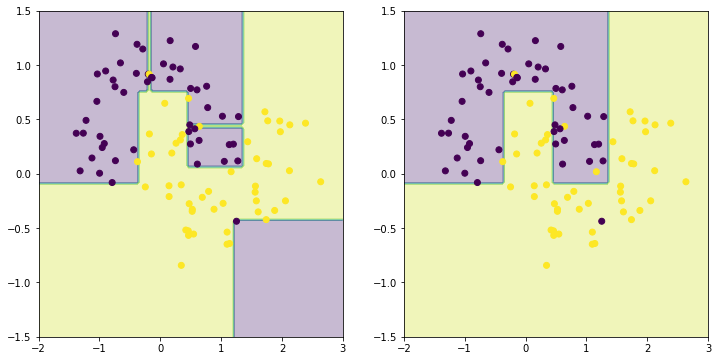

In [9]:
# Ejercicio

moon_tree_1 = DecisionTreeClassifier()
moon_tree_1.fit(Xm, ym)

moon_tree_2 = DecisionTreeClassifier(min_samples_leaf=5)
moon_tree_2.fit(Xm, ym)

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plot_decision_boundary(moon_tree_1, axes=[-2, 3, -1.5, 1.5])
plt.scatter(Xm[:,0], Xm[:,1], c=ym)

plt.subplot(1,2,2)
plot_decision_boundary(moon_tree_2, axes=[-2, 3, -1.5, 1.5])
plt.scatter(Xm[:,0], Xm[:,1], c=ym)

# Árboles de regresión
___

Hasta ahora hemos visto cómo resolver problemas de clasificación, pero los árboles también permiten resolver problemas de regresión. Veamos un ejemplo sencillo:

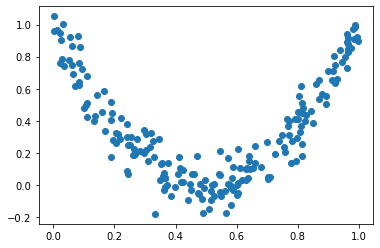

In [10]:
# Quadratic training set + noise
X = np.random.rand(200, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(200, 1) / 10

plt.scatter(X, y)

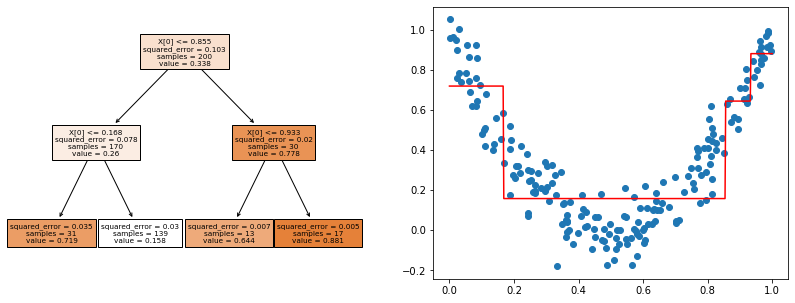

In [11]:
np.random.seed(5)
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
_ = plot_tree(tree_reg, filled=True)

plt.subplot(1,2,2)
x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred = tree_reg.predict(x1)
plt.scatter(X, y)
plt.plot(x1, y_pred, 'red')

La diferencia entre este árbol y el de clasificación es que mientras que el de clasificación predecía la clase a la que pertenecía una nueva observación, este arbol predice un valor. Por ejemplo, si la variable $X=0.2$ nos desplazaríamos hasta el nodo con valor $y=0.169$. Ese valor para la variable respuesta es la media de los valores para las $147$ observaciones en ese nodo. Mientras que en un árbol de clasificación se trabaja minimizando el nivel de impureza, en un árbol de regresión se minimiza el error cuadrático medio.

### <font color='D12828'> Ejercicio: </font>

* En el conjunto de datos anterior, entrena un árbol de regresión sin poner restricciones a los hiperparámetros
* Entrena un segundo árbol especificando `min_samples_leaf=10`
* Representa gráficamente el conjunto de datos y las predicciones para cada árbol

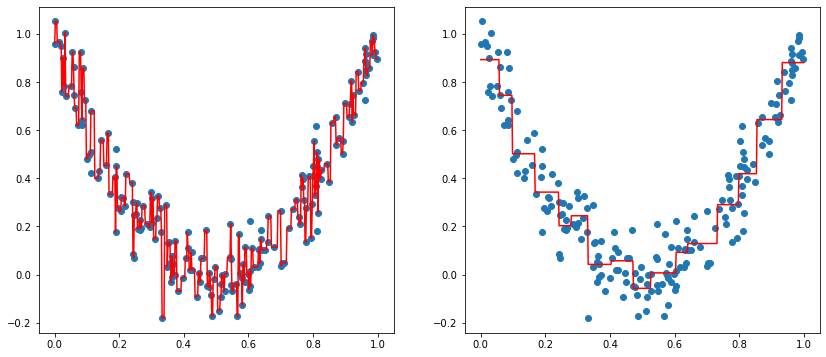

In [12]:
# Ejercicio

tree_reg_1 = DecisionTreeRegressor()
tree_reg_1.fit(X, y)
y_pred_1 = tree_reg_1.predict(x1)

tree_reg_2 = DecisionTreeRegressor(min_samples_leaf=10)
tree_reg_2.fit(X, y)
y_pred_2 = tree_reg_2.predict(x1)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.scatter(X, y)
plt.plot(x1, y_pred_1, 'red')

plt.subplot(1,2,2)
plt.scatter(X, y)
plt.plot(x1, y_pred_2, 'red')

# Inestabilidades
___

## Direcciones ortogonales
Hemos podido ver que los árboles son muy versátiles, y ofrecen ventajas como la interpretabilidad y la selección de variables que llevan a cabo como parte de su algoritmo, sin embargo tienen algunas limitaciones. Una de las principales limitaciones de estos algoritmos es el efecto que tiene en su capacidad predictiva una simple rotación de los datos. Veamos un ejemplo:

In [13]:
# Generamos conjuntos de datos
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

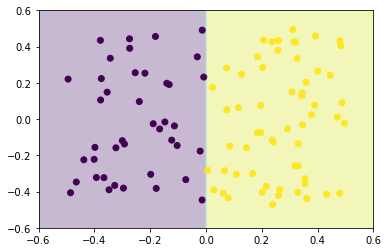

In [14]:
tree_clf_1 = DecisionTreeClassifier()
tree_clf_1.fit(Xs, ys)

plot_decision_boundary(tree_clf_1, [-0.6, 0.6, -0.6, 0.6])
plt.scatter(Xs[:,0], Xs[:,1], c=ys)


### <font color='D12828'> Ejercicio: </font>

* Entrena el mismo arbol en el conjunto de datos rotado 45 grados `Xsr`. Representalo gráficamente.

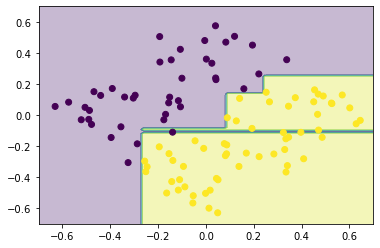

In [15]:
# Ejercicio

tree_clf_2 = DecisionTreeClassifier()
tree_clf_2.fit(Xsr, ys)

plot_decision_boundary(tree_clf_2, [-0.7, 0.7, -0.7, 0.7])
plt.scatter(Xsr[:,0], Xsr[:,1], c=ys)

Una solución a este problema es el uso de análisis de componentes principales, que proporcionan nuevas variables ortogonales entre si, lo que puede mejorar los resultados del árbol.

## Cambios en el conjunto de datos

Por otro lado, el algoritmo también se ve bastante afectado por cambios en el conjunto de datos. Por ejemplo, retomemos el caso del arbol de clasificación del inicio:

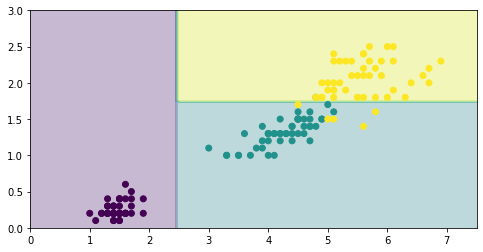

In [16]:
plt.figure(figsize=(8, 4))

plot_decision_boundary(tree_clf, axes=[0, 7.5, 0, 3])
plt.scatter(X_iris[:,0], X_iris[:,1], c=y_iris)

Si cambiamos el conjunto de datos, por ejemplo, eliminando una observación, esto puede dar lugar a grandes cambios en el arbol. Probemos a eliminar una observación que tiene una longitud de sepalo anormalmente grande (1.8) para el tipo de especie al que pertenece.

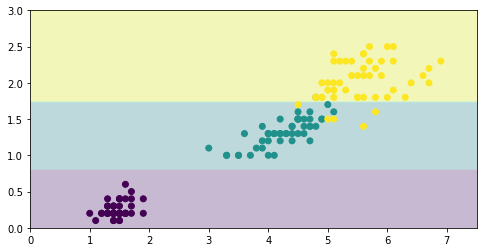

In [17]:
not_widest_versicolor = (X_iris[:, 1]!=1.8) | (y_iris==2)

X_tweaked = X_iris[not_widest_versicolor]
y_tweaked = y_iris[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, axes=[0, 7.5, 0, 3])
plt.scatter(X_iris[:,0], X_iris[:,1], c=y_iris)

# Conjunto de datos de boston

Veamos cómo aplicar los arboles de regresión a un conjunto de datos real. Para ello utilizaremos el conjunto de datos de __Boston Housing__, que ya vimos en la sesión de reducción de la dimensión. Este conjunto contiene información sobre el precio mediano de la vivienda en diferentes barrios de la ciudad de boston, así como una serie de variables socio-económicas de esos barrios. El objetivo de este problema es predecir el precio mediano de la vivienda en un barrio dadas el resto de variables. Empecemos descargando los datos.

In [18]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

boston = load_boston()
x_boston = pd.DataFrame(boston.data, columns = boston.feature_names)

y_boston = boston.target

x_boston.describe()

x_train, x_test, y_train, y_test = train_test_split(x_boston, y_boston, train_size=0.8, random_state=21)

C:\Users\alvaromc317\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing da

Representemos gráficamente la variable respuesta:

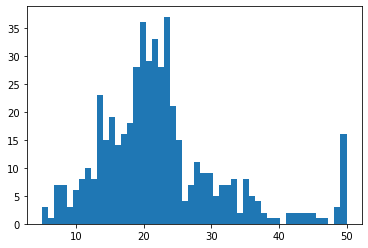

In [19]:
p = plt.hist(y_boston, bins=50)

## <font color='D12828'> Ejercicio final </font>
Utilizando el conjunto de datos de boston descargado antes, construye un arbol de regresión. Para ello:
* Utiliza la función `GridSearchCV` para buscar el valor óptimo de los hiperparámetros. Pista: el efecto de los parámetros es similar, así que puedes limitarte a cambiar uno de ellos, por ejemplo `min_samples_leaf`. Utiliza un valor elevado de `cv` para reducir en lo posible el sobre ajuste. Por ejemplo, `cv=10`.
* Obtén las predicciones finales de tu estimador en el conjunto de test y calcula el error cuadrático medio de tu arbol

In [20]:
# Ejercicio

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

tree_reg_boston = DecisionTreeRegressor()

param_grid = [{'min_samples_leaf': np.arange(2, 53, 5)}]

grid_search = GridSearchCV(tree_reg_boston, param_grid, cv=10)
grid_search.fit(x_train, y_train)

predicciones = grid_search.best_estimator_.predict(x_test)
mse_1 = mean_squared_error(y_test, predicciones)

print(f'Mean squared error: {np.round(mse_1, 3)}')


Mean squared error: 24.782


## <font color='D12828'> Ejercicio final (continuación)</font>
* Calcula las 13 componentes principales de este conjunto de datos y repite el proceso anterior (construye un arbol en este conjunto y obtén el MSE del conjunto de test). Pista: `from sklearn.decomposition import PCA`.

In [21]:
# Ejercicio

from sklearn.decomposition import PCA

pca = PCA(n_components=13)

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

tree_reg_boston = DecisionTreeRegressor()

param_grid = [{'min_samples_leaf': np.arange(2, 53, 5)}]

grid_search = GridSearchCV(tree_reg_boston, param_grid, cv=10)
grid_search.fit(x_train_pca, y_train)

predicciones = grid_search.best_estimator_.predict(x_test_pca)
mse_2 = mean_squared_error(y_test, predicciones)

print(f'Mean squared error: {np.round(mse_2, 3)}')

Mean squared error: 23.796


# Fin
___